# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
from collections import deque
import matplotlib.pyplot as plt
import torch
from agent import Agent
import time

# Hyperparameters

# First Model

In [7]:
# Reset environment for training
env_info = env.reset(train_mode=True)[brain_name]

In [8]:
N_EPISODES = 1500
PRINT_EVERY = 100
STOP_NOISE_AFTER=300       # episode to end the noise decay process
TARGET_SCORE = 0.5
SOLVED = 0.5
N_LEARN_UPDATES = 10       # number of steps before next update
BUFFER_SIZE=int(1e6)       # number of experiences that can be stored in buffer # replay buffer size
BATCH_SIZE=128             # number of experiences that are sampled by the buffer
GAMMA=0.99                 # discount factor
TAU=8e-3                   # for soft update of target parameters
SIGMA = 0.2                # Ornstein-Uhlenbeck noise parameter, volatility
THETA = 0.15               # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
LR_ACTOR=1e-3              # learning rate of the actor
LR_CRITIC=1e-3             # learning rate of the critic
WEIGHT_DECAY=0             # L2 weight decay
RANDOM_SEED=0

In [9]:
#Initialize Agent 1
agent1 = Agent(
    state_size=state_size,
    action_size=action_size,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

In [10]:
#Initialize Agent 2
agent2 = Agent(
    state_size=state_size,
    action_size=action_size,
    memory=agent1.memory, # To share memory between agents 
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

In [11]:
def maddpg(n_episodes=N_EPISODES, print_every=PRINT_EVERY):
    scores_deque = deque(maxlen=print_every)
    scores = []
    avg_scores = []
    agents_scores = []
    best_score = 0.0
    best_episode = 0
    add_noise = True
    already_solved = False  
    time_training_start = time.time()
    time_elapsed = 0
    
    for i_episode in range(1, n_episodes+1):
        if i_episode > STOP_NOISE_AFTER:
            add_noise = False
        time_episode_start = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        scores_ep = np.zeros(num_agents)
        while True:
            # Take a step: S-A-R-S'
            action1 = agent1.act(states[0], add_noise=add_noise).tolist()
            action2 = agent2.act(states[1], add_noise=add_noise).tolist()
            actions = [action1, action2]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            scores_ep += rewards
            states = next_states
            if np.any(dones):
                break
        
        agents_scores.append(scores_ep)
        max_score = np.max(scores_ep)
        scores_deque.append(max_score)
        scores.append(max_score)
        avg_scores.append(np.mean(scores_deque))
        
        if max_score > best_score:
            best_score = max_score
            best_episode = i_episode
            
        # Calculate the elapsed time
        time_episode = time.time() - time_episode_start
        time_elapsed = time.time() - time_training_start
        time_episode_str = time.strftime('%Mm%Ss', time.gmtime(time_episode))
        
        print('\rEpisode {} ({})\tAverage Score: {:.2f} \tBest_score {:.2f}'.format(i_episode,time_episode_str, np.mean(scores_deque), best_score), end="")
        torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        
        if i_episode % print_every == 0 or np.mean(scores_deque) >SOLVED:
            print('\nEpisode {} ({})\tAverage Score: {:.2f} \tBest_score {:.2f}'.format(i_episode,time_episode_str, np.mean(scores_deque), best_score), end="")
        
        if np.mean(scores_deque) >= TARGET_SCORE:
            if not already_solved:
                already_solved = True
                time_elapsed_str = time.strftime('%Hh%Mm%Ss', time.gmtime(time_elapsed))
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f} \tElapsed Time {}'.format(i_episode, np.mean(scores_deque),time_elapsed_str))
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
                torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
                torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
                break
        elif max_score >= best_score:
           # print('\rBest Episode until now! {} ({}) \tAverage Score: {:.2f}'.format(i_episode,time_elapsed, np.mean(scores_deque)))
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        
        elif (i_episode-best_episode) >= 400:
           # stop training if model stops converging
            print('\nTraining stopped. Model is not converging for the last 400 episodes')
            break
        
    return scores,agents_scores,avg_scores

# Train the model

In [12]:
scores,agents_scores,avg_scores = maddpg()

Episode 100 (00m00s)	Average Score: 0.00 	Best_score 0.00
Episode 200 (00m00s)	Average Score: 0.00 	Best_score 0.00
Episode 300 (00m00s)	Average Score: 0.00 	Best_score 0.00
Episode 400 (00m00s)	Average Score: 0.00 	Best_score 0.00
Episode 500 (00m00s)	Average Score: 0.01 	Best_score 0.10
Episode 600 (00m00s)	Average Score: 0.00 	Best_score 0.10
Episode 700 (00m00s)	Average Score: 0.00 	Best_score 0.10
Episode 800 (00m00s)	Average Score: 0.00 	Best_score 0.10
Episode 815 (00m00s)	Average Score: 0.00 	Best_score 0.10
Training stopped. Model is not converging for the last 400 episodes


# Plot results

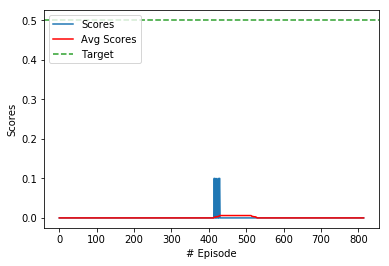

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), avg_scores, c='r', label='Avg Scores')
plt.ylabel('Scores')
plt.xlabel('# Episode')
plt.axhline(y=0.5, color='#2ca02c',linestyle="--",label='Target')
plt.legend(loc='upper left');
plt.show()

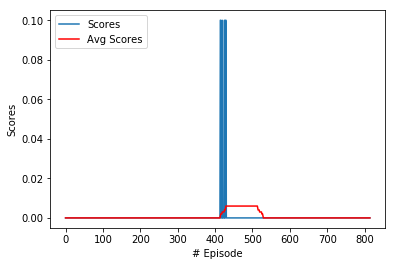

In [14]:
# plot the scores without the target, to see better the evolution
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), avg_scores, c='r', label='Avg Scores')
plt.ylabel('Scores')
plt.xlabel('# Episode')
plt.legend(loc='upper left');
plt.show()


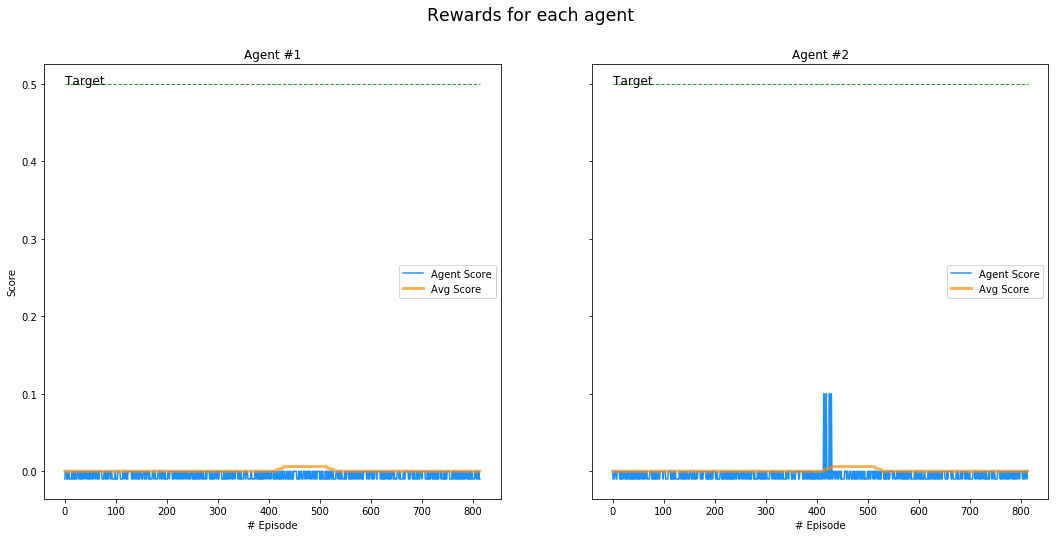

In [15]:
target = [TARGET_SCORE] * len(scores)

# Graphics for each one of the agents
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('Rewards for each agent', fontsize='xx-large')
axs = axs.flatten()
for idx, (ax, s) in enumerate(zip(axs, np.transpose(agents_scores))):
    ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
    ax.plot(avg_scores, label='Avg Score',
            color='DarkOrange', linewidth=3, alpha=0.655, zorder=2)
    ax.plot(target, linestyle='--', color='#2ca02c', linewidth=1, zorder=0)
    ax.text(0, TARGET_SCORE, 'Target',
            color='Black', fontsize='large')
    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('# Episode')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.show()

# Second Model with different hyperparameters

In [16]:
N_EPISODES = 1500
TARGET_SCORE = 0.5
PRINT_EVERY = 100
STOP_NOISE_AFTER=300
N_LEARN_UPDATES = 10 # number of steps before next update
BUFFER_SIZE=int(1e6) #number of experiences that can be stored in buffer
BATCH_SIZE=512 # number of experiences that are sampled by the buffer
#BATCH_SIZE=256
GAMMA=0.99     
TAU=1e-2
LR_ACTOR=1e-3     
LR_CRITIC=1e-3      
WEIGHT_DECAY=0
RANDOM_SEED=0

In [17]:
#Initialize Agent 1
agent1 = Agent(
    state_size=state_size,
    action_size=action_size,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

In [18]:
#Initialize Agent 2
agent2 = Agent(
    state_size=state_size,
    action_size=action_size,
    memory=agent1.memory, # To share memory between agents 
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

In [19]:
scores,agents_scores,avg_scores = maddpg()

Episode 100 (00m00s)	Average Score: 0.00 	Best_score 0.10
Episode 200 (00m00s)	Average Score: 0.00 	Best_score 0.10
Episode 300 (00m00s)	Average Score: 0.00 	Best_score 0.10
Episode 400 (00m00s)	Average Score: 0.04 	Best_score 0.10
Episode 421 (00m00s)	Average Score: 0.04 	Best_score 0.10
Training stopped. Model is not converging for the last 400 episodes


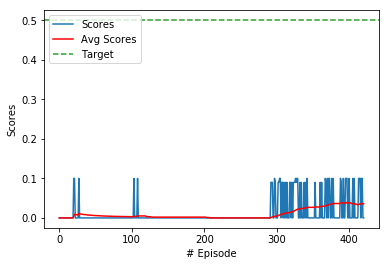

In [20]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), avg_scores, c='r', label='Avg Scores')
plt.ylabel('Scores')
plt.xlabel('# Episode')
plt.axhline(y=0.5, color='#2ca02c',linestyle="--",label='Target')
plt.legend(loc='upper left');
plt.show()

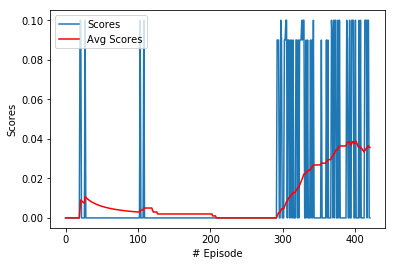

In [21]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), avg_scores, c='r', label='Avg Scores')
plt.ylabel('Scores')
plt.xlabel('# Episode')
plt.legend(loc='upper left');
plt.show()

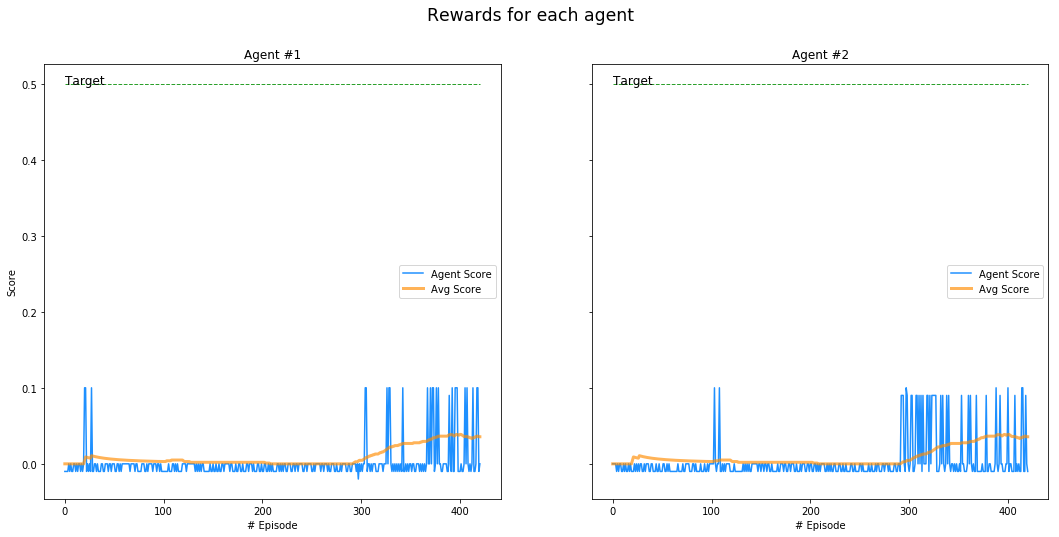

In [22]:
target = [TARGET_SCORE] * len(scores)

# Graphics for each one of the agents
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('Rewards for each agent', fontsize='xx-large')
axs = axs.flatten()
for idx, (ax, s) in enumerate(zip(axs, np.transpose(agents_scores))):
    ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
    ax.plot(avg_scores, label='Avg Score',
            color='DarkOrange', linewidth=3, alpha=0.655, zorder=2)
    ax.plot(target, linestyle='--', color='#2ca02c', linewidth=1, zorder=0)
    ax.text(0, TARGET_SCORE, 'Target',
            color='Black', fontsize='large')
    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('# Episode')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.show()

# Third Try

In [23]:
STOP_NOISE_AFTER=300       # episode to end the noise decay process
TARGET_SCORE = 0.5
N_LEARN_UPDATES = 10       # number of steps before next update
BUFFER_SIZE=int(1e6)       # number of experiences that can be stored in buffer # replay buffer size
BATCH_SIZE=128             # number of experiences that are sampled by the buffer
GAMMA=0.99                 # discount factor
TAU=1e-2                   # for soft update of target parameters
LR_ACTOR=1e-3              # learning rate of the actor
LR_CRITIC=1e-3             # learning rate of the critic
WEIGHT_DECAY=0             # L2 weight decay
RANDOM_SEED=0

In [24]:
scores,agents_scores,avg_scores = maddpg()

Episode 100 (00m00s)	Average Score: 0.00 	Best_score 0.09
Episode 200 (00m00s)	Average Score: 0.00 	Best_score 0.10
Episode 300 (00m01s)	Average Score: 0.01 	Best_score 0.10
Episode 400 (00m01s)	Average Score: 0.13 	Best_score 0.90
Episode 500 (00m13s)	Average Score: 0.21 	Best_score 1.00
Episode 600 (00m07s)	Average Score: 0.41 	Best_score 1.49
Episode 700 (00m02s)	Average Score: 0.35 	Best_score 2.19
Episode 770 (00m09s)	Average Score: 0.50 	Best_score 2.60
Episode 770 (00m09s)	Average Score: 0.50 	Best_score 2.60
Environment solved in 770 episodes!	Average Score: 0.50 	Elapsed Time 00h47m33s


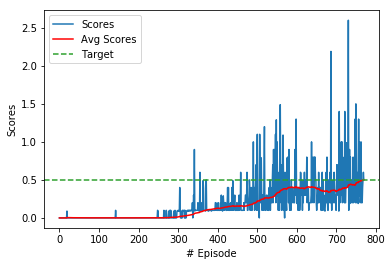

In [25]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), avg_scores, c='r', label='Avg Scores')
plt.ylabel('Scores')
plt.xlabel('# Episode')
plt.axhline(y=0.5, color='#2ca02c',linestyle="--",label='Target')
plt.legend(loc='upper left');
plt.show()

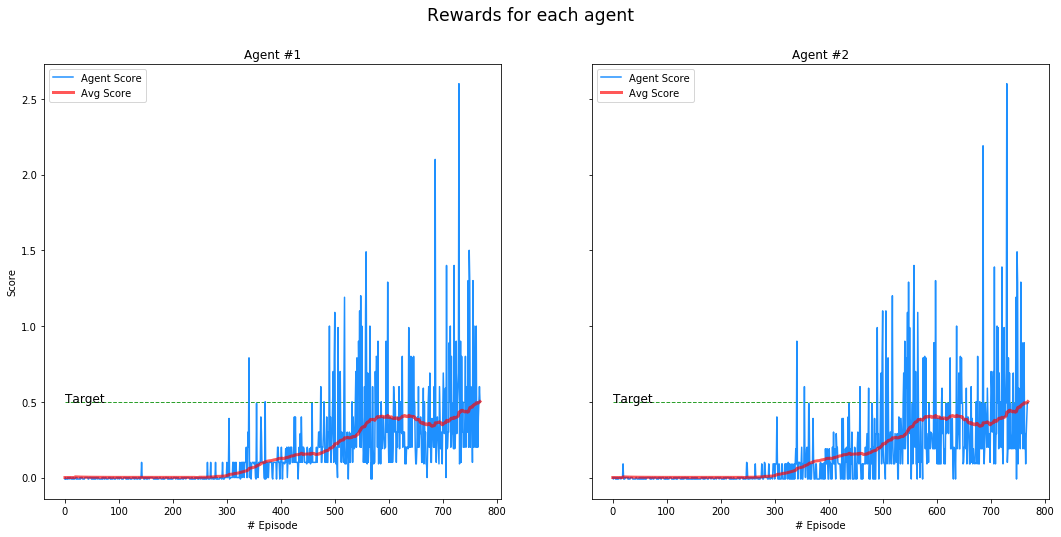

In [26]:
target = [TARGET_SCORE] * len(scores)

# Graphics for each one of the agents
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('Rewards for each agent', fontsize='xx-large')
axs = axs.flatten()
for idx, (ax, s) in enumerate(zip(axs, np.transpose(agents_scores))):
    ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
    ax.plot(avg_scores, label='Avg Score',
            color='Red', linewidth=3, alpha=0.655, zorder=2)
    ax.plot(target, linestyle='--', color='#2ca02c', linewidth=1, zorder=0)
    ax.text(0, TARGET_SCORE, 'Target',
            color='Black', fontsize='large')
    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('# Episode')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.show()

# Fourth and Best Model

In [27]:
STOP_NOISE_AFTER=300       # episode to end the noise decay process
TARGET_SCORE = 0.5
N_LEARN_UPDATES = 10       # number of steps before next update
BUFFER_SIZE=int(1e6)       # number of experiences that can be stored in buffer # replay buffer size
BATCH_SIZE=128             # number of experiences that are sampled by the buffer
GAMMA=0.99                 # discount factor
TAU=8e-3                   # for soft update of target parameters
SIGMA = 0.2                # Ornstein-Uhlenbeck noise parameter, volatility
THETA = 0.15               # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
LR_ACTOR=1e-3              # learning rate of the actor
LR_CRITIC=1e-3             # learning rate of the critic
WEIGHT_DECAY=0             # L2 weight decay
RANDOM_SEED=0

In [28]:
scores,agents_scores,avg_scores = maddpg()

Episode 100 (00m00s)	Average Score: 0.10 	Best_score 0.30
Episode 200 (00m01s)	Average Score: 0.07 	Best_score 0.30
Episode 300 (00m04s)	Average Score: 0.08 	Best_score 0.30
Episode 340 (00m47s)	Average Score: 0.52 	Best_score 2.60
Episode 340 (00m47s)	Average Score: 0.52 	Best_score 2.60
Environment solved in 340 episodes!	Average Score: 0.52 	Elapsed Time 00h23m27s


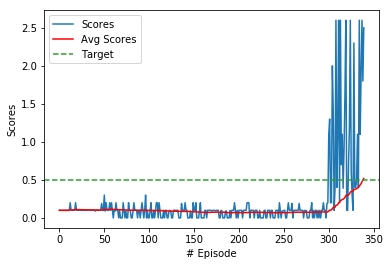

In [29]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), avg_scores, c='r', label='Avg Scores')
plt.ylabel('Scores')
plt.xlabel('# Episode')
plt.axhline(y=0.5, color='#2ca02c',linestyle="--",label='Target')
plt.legend(loc='upper left');
plt.show()

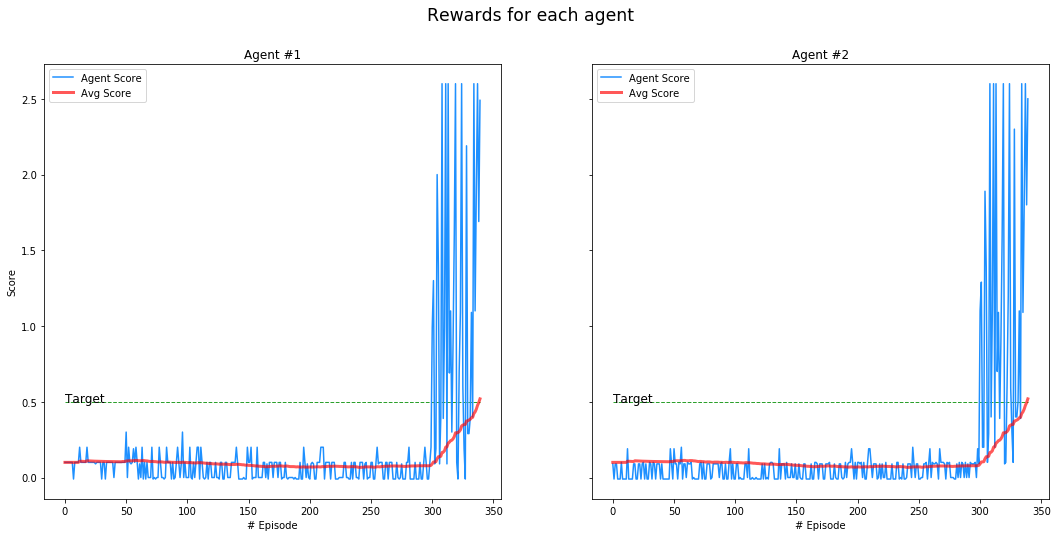

In [30]:
target = [TARGET_SCORE] * len(scores)

# Graphics for each one of the agents
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('Rewards for each agent', fontsize='xx-large')
axs = axs.flatten()
for idx, (ax, s) in enumerate(zip(axs, np.transpose(agents_scores))):
    ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
    ax.plot(avg_scores, label='Avg Score',
            color='Red', linewidth=3, alpha=0.655, zorder=2)
    ax.plot(target, linestyle='--', color='#2ca02c', linewidth=1, zorder=0)
    ax.text(0, TARGET_SCORE, 'Target',
            color='Black', fontsize='large')
    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('# Episode')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.show()

# Test the best saved agent

In [31]:
## Load the trained model
agent1 = Agent(state_size=state_size, action_size=action_size,buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,gamma=GAMMA,tau=TAU,lr_actor=LR_ACTOR,lr_critic=LR_CRITIC,weight_decay=WEIGHT_DECAY,random_seed=10)
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor1.pth'))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic1.pth'))

#agent2 = Agent(state_size=state_size, action_size=action_size,n_learn_updates= N_LEARN_UPDATES, random_seed=10)
agent2 = Agent(state_size=state_size, action_size=action_size,buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,gamma=GAMMA,tau=TAU,lr_actor=LR_ACTOR,lr_critic=LR_CRITIC,weight_decay=WEIGHT_DECAY,random_seed=10)
agent2.actor_local.load_state_dict(torch.load('checkpoint_actor2.pth'))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic2.pth'))

In [32]:
for i in range(1, 10):                                     # play game for 9 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        action1 = agent1.act(states[0], add_noise=False).tolist()
        action2 = agent2.act(states[1], add_noise=False).tolist()
        actions = [action1, action2]
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode is finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode is finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352
Score (max over agents) from episode 3: 2.600000038743019
Score (max over agents) from episode 4: 0.30000000447034836
Score (max over agents) from episode 5: 1.5000000223517418
Score (max over agents) from episode 6: 2.600000038743019
Score (max over agents) from episode 7: 1.0000000149011612
Score (max over agents) from episode 8: 0.7000000104308128
Score (max over agents) from episode 9: 0.10000000149011612


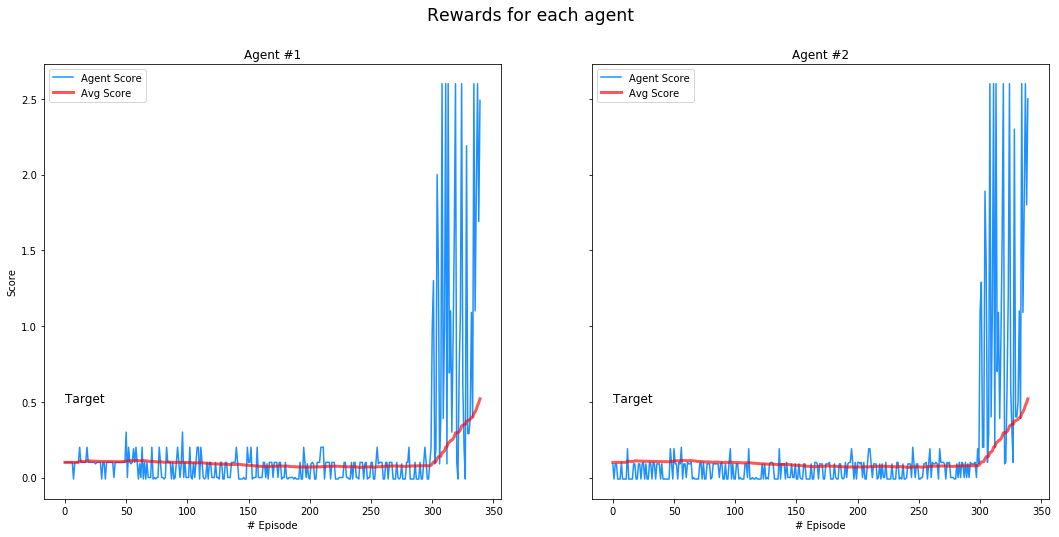

In [33]:
# Graphics for each one of the agents
target = [TARGET_SCORE] * len(scores)

# Graphics for each one of the agents
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('Rewards for each agent', fontsize='xx-large')
axs = axs.flatten()
for idx, (ax, s) in enumerate(zip(axs, np.transpose(agents_scores))):
    ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
    ax.plot(avg_scores, label='Avg Score',
            color='Red', linewidth=3, alpha=0.655, zorder=2)
    ax.plot(target, linestyle='--', color='#2ca02c', linewidth=1, zorder=0)
    ax.text(0, TARGET_SCORE, 'Target',
            color='Black', fontsize='large')
    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('# Episode')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.show()

In [34]:
## reinitialize the agents
agent1 = Agent(state_size=state_size, action_size=action_size,buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,gamma=GAMMA,tau=TAU,lr_actor=LR_ACTOR,lr_critic=LR_CRITIC,weight_decay=WEIGHT_DECAY,random_seed=10)
agent2 = Agent(state_size=state_size, action_size=action_size,buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,gamma=GAMMA,tau=TAU,lr_actor=LR_ACTOR,lr_critic=LR_CRITIC,weight_decay=WEIGHT_DECAY,random_seed=10)

# load the best weights from file
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor1.pth'))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic1.pth'))

agent2.actor_local.load_state_dict(torch.load('checkpoint_actor2.pth'))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic2.pth'))

In [35]:
WITH_NOISE = False
N_EPISODES_TEST = 10
LEN_EPISODES = 10
PRINT_EVERY = 1

In [ ]:
for i in range(1, 10):                                     # play game for 9 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        action1 = agent1.act(states[0], add_noise=False).tolist()
        action2 = agent2.act(states[1], add_noise=False).tolist()
        actions = [action1, action2]
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode is finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode is finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 2.600000038743019
Score (max over agents) from episode 4: 2.7000000402331352


In [ ]:
# Graphics for each one of the agents
target = [TARGET_SCORE] * len(scores)

# Graphics for each one of the agents
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
fig.suptitle('Rewards for each agent', fontsize='xx-large')
axs = axs.flatten()
for idx, (ax, s) in enumerate(zip(axs, np.transpose(agents_scores))):
    ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=1)
    ax.plot(avg_scores, label='Avg Score',
            color='Red', linewidth=3, alpha=0.655, zorder=2)
    ax.plot(target, linestyle='--', color='#2ca02c', linewidth=1, zorder=0)
    ax.text(0, TARGET_SCORE, 'Target',
            color='Black', fontsize='large')
    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('# Episode')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.show()

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 